# Building a Pokedex in Python:

### Import Packages

In [1]:
# import the necessary packages
from imutils.paths import list_images
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from skimage import exposure
import pandas as pd
import numpy as np
import argparse
import requests
import pickle
import imutils
import cv2
import os

### Function to display images in Jupyter Notebooks and Google Colab

In [2]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

## Step 2/6: Scraping the Pokemon Sprites

### Scraping and Downloading


In [22]:
'''
# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-p", "--pokemon-list", required = True,
	help = "Path to where the raw Pokemon HTML file resides")
ap.add_argument("-s", "--sprites", required = True,
	help = "Path where the sprites will be stored")
ap.add_argument("-i", "--index", required = True,
	help = "Path to where the index file will be stored")
args = vars(ap.parse_args())

"https://pokemondb.net/pokedex/national"
'''
args01 = {
    "pokemon_link" : "https://pokemondb.net/pokedex/game/red-blue-yellow",
    "sprite_type"  : ".png",
    "path_sprites" : "datasets/pokemon01/sprites",
    "path_index"   : "datasets/pokemon01/index.cpickle",
    "path_querry"   : "data/screen/query_marowak.jpg",
    "path_cropped"   : "data/screen/cropped.png"
}

args = {
    "pokemon_link" : "https://pokemondb.net/pokedex/national",
    "sprite_type"  : ".png",
    "path_sprites" : "datasets/pokemon/sprites",
    "path_index"   : "datasets/pokemon/index.cpickle",
    "path_querry"   : "data/screen/query_marowak.jpg",
    "path_cropped"   : "data/screen/cropped.png"
}

In [4]:
# Step 1: Use the requests library to grab the page
# Note, this may fail if you have a firewall blocking Python/Jupyter 
# Note sometimes you need to run this twice if it fails the first time
res = requests.get(args["pokemon_link"])
#type(res)
#res.text

In [5]:
soup = BeautifulSoup(res.text,"lxml")
#soup

In [6]:
title_tag = soup.select('title')
#title_tag[0]
#type(title_tag[0])
title_tag[0].getText()

'Pokémon Red/Blue/Yellow - Kanto Pokédex | Pokémon Database'

<table>

<thead >
<tr>
<th>
<p>Syntax to pass to the .select() method</p>
</th>
<th>
<p>Match Results</p>
</th>
</tr>
</thead>
<tbody>
<tr>
<td>
<p><code>soup.select('div')</code></p>
</td>
<td>
<p>All elements with the <code>&lt;div&gt;</code> tag</p>
</td>
</tr>
<tr>
<td>
<p><code>soup.select('#some_id')</code></p>
</td>
<td>
<p>The HTML element containing the <code>id</code> attribute of <code>some_id</code></p>
</td>
</tr>
<tr>
<td>
<p><code>soup.select('.notice')</code></p>
</td>
<td>
<p>All the HTML elements with the CSS <code>class</code> named <code>notice</code></p>
</td>
</tr>
<tr>
<td>
<p><code>soup.select('div span')</code></p>
</td>
<td>
<p>Any elements named <code>&lt;span&gt;</code> that are within an element named <code>&lt;div&gt;</code></p>
</td>
</tr>
<tr>
<td>
<p><code>soup.select('div &gt; span')</code></p>
</td>
<td>
<p>Any elements named <code class="literal2">&lt;span&gt;</code> that are <span><em >directly</em></span> within an element named <code class="literal2">&lt;div&gt;</code>, with no other element in between</p>
</td>
</tr>
<tr>

</tr>
</tbody>
</table>

In [11]:
# List of pokemon name
# content of class="ent-name"
pokemon_list = set()
for item in soup.select(".ent-name"):
    pokemon_list.add(item.text)
#pokemon_list

In [19]:
# class=".img-fixed img-sprite" => class1 is "img-fixed", class2 is "img-sprite"
sprite_info = soup.select('.img-sprite')
#sprite_info
#len(sprite_info)
pokemon_sprite = sprite_info[0]
pokemon_sprite
#type(pokemon_sprite)
#pokemon_sprite['data-src']
#pokemon_sprite['data-alt'][:-7]
#pokemon_sprite['src']
#pokemon_sprite['alt']

'Bulbasaur'

In [20]:
for img_sprite in sprite_info:
    #link_sprite = img_sprite['data-src']
    link_sprite = img_sprite['src']
    # download img-sprite 
    img = requests.get(link_sprite)
    
    #image_name = img_sprite['data-alt'][:-7].lower()+args["sprite_type"]
    image_name = img_sprite['alt'].lower()+args["sprite_type"]
    image_path = os.path.sep.join([args["path_sprites"],image_name])
    
    f = open(image_path,'wb')
    f.write(img.content)
    f.close()

## Step 3 :Indexing our Sprites using Shape Descriptors 
### Zernike Moments

Image moments are used to describe objects in an image. Using image moments you can calculate values such as the area of the object, the centroid (the center of the object, in terms of x, y coordinates), and information regarding how the object is rotated. Normally, we calculate image moments based on the contour or outline of an image, but this is not a requirement.

Similar to Hu moments, Zernike moments are used to describe the shape of an object; however, since the Zernike polynomials are orthogonal to each other, there is no redundancy of information between the moments.

In [32]:
# import the necessary packages
import mahotas

In [33]:
class ZernikeMoments:
	def __init__(self, radius):
		# store the size of the radius that will be
		# used when computing moments
		self.radius = radius
	
	def describe(self, image):
		# return the Zernike moments for the image
		return mahotas.features.zernike_moments(image, self.radius)

In [34]:
# initialize our descriptor (Zernike Moments with a radius
# of 21 used to characterize the shape of our pokemon) and
# our index dictionary
desc = ZernikeMoments(21)
index = {}

In [35]:
'''
spritePath = list(list_images(args["path_sprites"]))[0]
#s[s.rfind("/") + 1:].replace(".png", "")
pokemon = spritePath[spritePath.rfind("/") + 1:].replace(".png", "")
image = cv2.imread(spritePath)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image[image ==0] = 255
plt_imshow(pokemon,image)

image = cv2.copyMakeBorder(image, 15, 15, 15, 15, cv2.BORDER_CONSTANT, value = 255)
plt_imshow(pokemon,image)

thresh = cv2.bitwise_not(image)
#thresh[thresh > 0] = 255

plt_imshow(pokemon+' Thresh',thresh)

outline = np.zeros(image.shape, dtype = "uint8")
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
		cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
cv2.drawContours(outline, [cnts], -1, 255, -1)

plt_imshow(pokemon+' Outline',outline)
'''

'\nspritePath = list(list_images(args["path_sprites"]))[0]\n#s[s.rfind("/") + 1:].replace(".png", "")\npokemon = spritePath[spritePath.rfind("/") + 1:].replace(".png", "")\nimage = cv2.imread(spritePath)\nimage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)\nimage[image ==0] = 255\nplt_imshow(pokemon,image)\n\nimage = cv2.copyMakeBorder(image, 15, 15, 15, 15, cv2.BORDER_CONSTANT, value = 255)\nplt_imshow(pokemon,image)\n\nthresh = cv2.bitwise_not(image)\n#thresh[thresh > 0] = 255\n\nplt_imshow(pokemon+\' Thresh\',thresh)\n\noutline = np.zeros(image.shape, dtype = "uint8")\ncnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,\n\t\tcv2.CHAIN_APPROX_SIMPLE)\ncnts = imutils.grab_contours(cnts)\ncnts = sorted(cnts, key = cv2.contourArea, reverse = True)[0]\ncv2.drawContours(outline, [cnts], -1, 255, -1)\n\nplt_imshow(pokemon+\' Outline\',outline)\n'

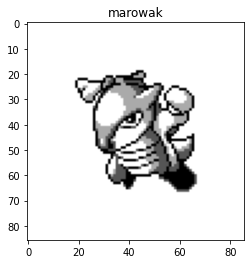

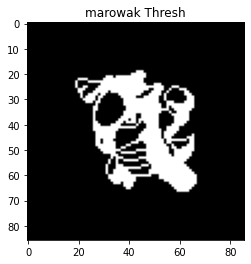

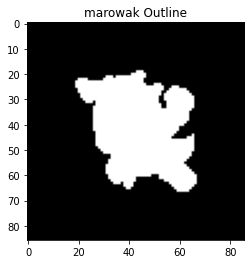

In [40]:
# loop over the sprite images
for (idx, spritePath) in enumerate(list_images(args01["path_sprites"])):
	# parse out the pokemon name, then load the image and
	# convert it to grayscale
	pokemon = spritePath[spritePath.rfind("/") + 1:].replace(".png", "")
	image = cv2.imread(spritePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Fill background with WHITE if use args
	#image[image ==0] = 255
	
    # pad the image with extra white pixels to ensure the
	# edges of the pokemon are not up against the borders
	# of the image
	image = cv2.copyMakeBorder(image, 15, 15, 15, 15,
		cv2.BORDER_CONSTANT, value = 255)
	
    # invert the image and threshold it
	thresh = cv2.bitwise_not(image)
	thresh[thresh > 0] = 255

    # initialize the outline image, find the outermost
	# contours (the outline) of the pokemone, then draw
	# it
	outline = np.zeros(image.shape, dtype = "uint8")
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
		cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
	cv2.drawContours(outline, [cnts], -1, 255, -1)

	if  pokemon == 'marowak' :
		plt_imshow(pokemon,image)
		plt_imshow(pokemon+' Thresh',thresh)
		plt_imshow(pokemon+' Outline',outline)
    
    # compute Zernike moments to characterize the shape
	# of pokemon outline, then update the index
	moments = desc.describe(outline)
	index[pokemon] = moments

In [37]:
# write the index to file
f = open(args01["path_index"], "wb")
f.write(pickle.dumps(index))
f.close()

In [38]:
index['marowak']

array([0.31830989, 0.00363293, 0.07899212, 0.03707118, 0.0243274 ,
       0.02704318, 0.04783488, 0.01356761, 0.04734207, 0.02696991,
       0.02897374, 0.06775264, 0.01540434, 0.00314225, 0.02373769,
       0.01618558, 0.00089042, 0.02823813, 0.01932235, 0.048291  ,
       0.00508886, 0.00917269, 0.01736882, 0.02489345, 0.02150965])

## Step 4: Building a Pokedex in Python: Finding the Game Boy Screen

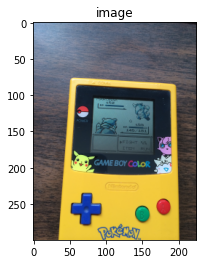

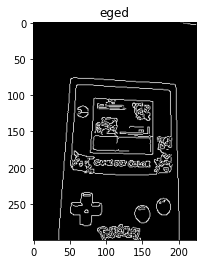

In [11]:
# load the query image, compute the ratio of the old height
# to the new height, clone it, and resize it
image = cv2.imread(args01["path_querry"])
ratio = image.shape[0] / 300.0
orig = image.copy()
image = imutils.resize(image, height = 300)
plt_imshow('image', image)

# convert the image to grayscale, blur it, and find edges
# in the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.bilateralFilter(gray, 11, 17, 17)
edged = cv2.Canny(gray, 30, 200)

plt_imshow('eged', edged)

In [12]:
# find contours in the edged image, keep only the largest
# ones, and initialize our screen contour
cnts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:10]
screenCnt = None

In [13]:
# loop over our contours
for c in cnts:
	# approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.015 * peri, True)
	# if our approximated contour has four points, then
	# we can assume that we have found our screen
	if len(approx) == 4:
		screenCnt = approx
		break

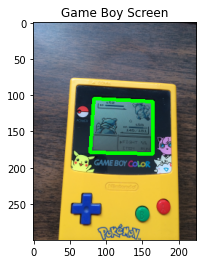

In [14]:
cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 3) 
plt_imshow("Game Boy Screen", image) 

In [15]:
# now that we have our screen contour, we need to determine
# the top-left, top-right, bottom-right, and bottom-left
# points so that we can later warp the image -- we'll start
# by reshaping our contour to be our finals and initializing
# our output rectangle in top-left, top-right, bottom-right,
# and bottom-left order
pts = screenCnt.reshape(4, 2)
rect = np.zeros((4, 2), dtype = "float32")

# the top-left point has the smallest sum whereas the
# bottom-right has the largest sum
s = pts.sum(axis = 1)
rect[0] = pts[np.argmin(s)]
rect[2] = pts[np.argmax(s)]

# compute the difference between the points -- the top-right
# will have the minumum difference and the bottom-left will
# have the maximum difference
diff = np.diff(pts, axis = 1)
rect[1] = pts[np.argmin(diff)]
rect[3] = pts[np.argmax(diff)]

# multiply the rectangle by the original ratio
rect *= ratio

# now that we have our rectangle of points, let's compute
# the width of our new image
(tl, tr, br, bl) = rect
widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))

# ...and now for the height of our new image
heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))

# take the maximum of the width and height values to reach
# our final dimensions
maxWidth = max(int(widthA), int(widthB))
maxHeight = max(int(heightA), int(heightB))

# construct our destination points which will be used to
# map the screen to a top-down, "birds eye" view
dst = np.array([
	[0, 0],
	[maxWidth - 1, 0],
	[maxWidth - 1, maxHeight - 1],
	[0, maxHeight - 1]], dtype = "float32")

# calculate the perspective transform matrix and warp
# the perspective to grab the screen
M = cv2.getPerspectiveTransform(rect, dst)
warp = cv2.warpPerspective(orig, M, (maxWidth, maxHeight))

# convert the warped image to grayscale and then adjust
# the intensity of the pixels to have minimum and maximum
# values of 0 and 255, respectively
warp = cv2.cvtColor(warp, cv2.COLOR_BGR2GRAY)
warp = exposure.rescale_intensity(warp, out_range = (0, 255))

# the pokemon we want to identify will be in the top-right
# corner of the warped image -- let's crop this region out
(h, w) = warp.shape
(dX, dY) = (int(w * 0.4), int(h * 0.45))
crop = warp[10:dY, w - dX:w - 10]

# save the cropped image to file
cv2.imwrite("cropped.png", crop)

True

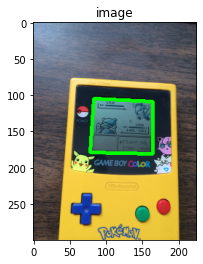

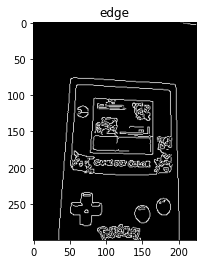

error: OpenCV(4.5.2) /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-7jsmxh8y/opencv/modules/imgproc/src/color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function 'cv::impl::(anonymous namespace)::CvtHelper<cv::impl::(anonymous namespace)::Set<1, -1, -1>, cv::impl::(anonymous namespace)::Set<3, 4, -1>, cv::impl::(anonymous namespace)::Set<0, 2, 5>, cv::impl::(anonymous namespace)::NONE>::CvtHelper(cv::InputArray, cv::OutputArray, int) [VScn = cv::impl::(anonymous namespace)::Set<1, -1, -1>, VDcn = cv::impl::(anonymous namespace)::Set<3, 4, -1>, VDepth = cv::impl::(anonymous namespace)::Set<0, 2, 5>, sizePolicy = cv::impl::(anonymous namespace)::NONE]'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


In [62]:
# show our images
plt_imshow("image", image)
plt_imshow("edge", edged)
#plt_imshow("warp", imutils.resize(warp, height = 300))
#plt_imshow("crop", imutils.resize(crop, height = 300))
plt_imshow("crop", crop)
plt_imshow("warp", warp)


## Comparing Shape Descriptors with OpenCV (Step 6 of 6)

In [42]:
# import the necessary packages
from scipy.spatial import distance as dist

In [43]:
class Searcher:
	def __init__(self, index):
		# store the index that we will be searching over
		self.index = index
	def search(self, queryFeatures):
		# initialize our dictionary of results
		results = {}
		# loop over the images in our index
		for (k, features) in self.index.items():
			# compute the distance between the query features
			# and features in our index, then update the results
			d = dist.euclidean(queryFeatures, features)
			results[k] = d
		# sort our results, where a smaller distance indicates
		# higher similarity
		results = sorted([(v, k) for (k, v) in results.items()])
		# return the results
		return results


In [44]:
# load the index
index = open(args01["path_index"], "rb").read()
index = pickle.loads(index)

In [45]:
# load the query image, convert it to grayscale, and
# resize it
image = cv2.imread(args01["path_cropped"])
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = imutils.resize(image, width = 64)

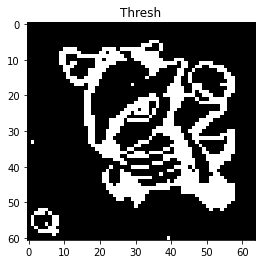

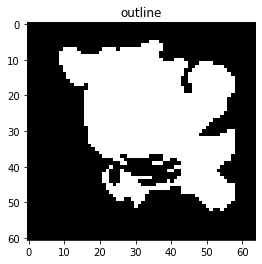

In [46]:
# threshold the image
thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
	cv2.THRESH_BINARY_INV, 11, 7)
plt_imshow("Thresh", thresh)
# initialize the outline image, find the outermost
# contours (the outline) of the pokemon, then draw
# it
outline = np.zeros(image.shape, dtype = "uint8")
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
cv2.drawContours(outline, [cnts], -1, 255, -1)
plt_imshow("outline", outline)

That pokemon is: VICTREEBEL


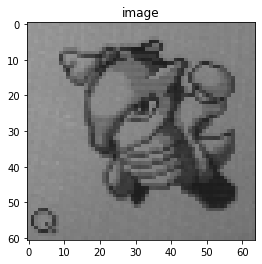

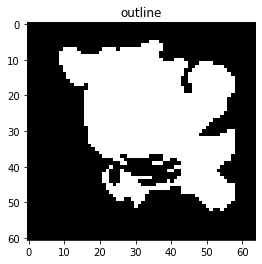

In [31]:
# compute Zernike moments to characterize the shape of
# pokemon outline
desc = ZernikeMoments(21)
queryFeatures = desc.describe(outline)

# perform the search to identify the pokemon
searcher = Searcher(index)
results = searcher.search(queryFeatures)
print ("That pokemon is: %s" % results[0][1].upper())

# show our images
plt_imshow("image", image)
plt_imshow("outline", outline)